# Run WFlow upper Zambezi - Lisflood-FP Barotse fully coupled #

Test 1D-2D coupling function. Here it concerns particularly the testing of the exchange from Lisflood to wflow through the snow store. We are tersting an adapted update() function for lisflood that estimates infiltration per lisflood adaptive time step on the basis of 2 constraints: 
- storage capacity. This is estimated in millimetres qater equivalent, by (wflow variable names) SoilWaterCapacity - SoilWaterDepth - UStoreDepth 
- infiltration capacity. This can be a simple limit in mm/hour, on-the-fly converted to mm/timestep.


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import rasterio
import sys, os
from datetime import datetime

# import Glofrim
from glofrim import Glofrim

# import barotse utils (first add path to be able to recognize it
sys.path.append('../utils')
import utils


In [2]:
def update_glofrim(self, dt=None, **kwargs):
    """Updating model for a certain time step interval (default: None).
    checks whether model end time is already reached;
    requires that model-specific time step is a whole number of update time step.

    Keyword Arguments:
        dt {int} -- update time step interval [sec] at which information is exchanged between models (default: {None})

    Raises:
        Warning -- Raised in models are not initialized before updating
        Exception -- Raised if model end time is already reached; no further updating possible
    """
    from datetime import datetime, timedelta

    if not self.initialized:
        msg = "models should be initialized first"
        self.logger.warn(msg)
        raise Warning(msg)
    if self._t >= self.get_end_time():
        msg = "endTime already reached, model not updated"
        self.logger.warn(msg)
        raise Exception(msg)
    # update all models with combined model dt
    wb_dict = {'time': str(self._t)}
    dt = self._dt.total_seconds() if dt is None else dt
    t_next = self._t + timedelta(seconds=dt)
    for item in self.exchanges:
        if item[0] == 'update':
            # LFP deviates from the set timestep using an adaptive timestep if dt is set to large
            # calculate the dt to get to the next timestep
            # NOTE we use "update" instead of "update_until" to getter better logging.
            imod = item[1]
            dt_mod = (t_next - self.bmimodels[imod]._t).total_seconds()
            # adapted for infiltration H.C. Winsemius
            if imod == 'LFP':
                self.bmimodels[imod].update(dt=dt_mod, **kwargs)
            else:
                self.bmimodels[imod].update(dt=dt_mod)
                
            # get volume totals in and out if the bmi object has this funtion, ortherwise return -9999
            tot_volume_in = getattr(self.bmimodels[imod], '_get_tot_volume_in', lambda: -9999.)()
            wb_dict.update({'{}_tot_in'.format(imod): '{:.2f}'.format(tot_volume_in)})
            tot_volume_out = getattr(self.bmimodels[imod], '_get_tot_volume_out', lambda: -9999.)()
            wb_dict.update({'{}_tot_out'.format(imod): '{:.2f}'.format(tot_volume_out)})
        elif item[0] == 'exchange':
            tot_volume = self.exchange(**item[1])
            wb_dict.update({item[1]['name']: '{:.2f}'.format(tot_volume)})
    # write water balance volumes to file according to header
    self.wb_logger.info(', '.join([wb_dict[c] for c in self._wb_header]))
    self._t = self.get_current_time()

def update_lfp(self, dt=None, infiltcap=None, storagecap=None, infiltdt=3600):
    """
    refactoring (monkey patch) of lisflood GLOFRIM update function to be able to account for infiltration
    inputs:
        dt: time step in secs. (if not specified, taken from model instance)
        infiltcap: infiltration capacity in mm s-1
        storagecap: available storage capacity left over in the soil in mm
        infiltdt: frequency by which to update the infiltration
        
    """
    def infilt():
        """
        Determine infiltration over time step
        """
        # get water level above channel depth
        h = self._bmi.get_var('H')
        flood_depth = np.maximum(h+z-dem, 0)
        current_infilt_cap = infiltcap*((self._t - t_current_infilt).total_seconds())/1000 # infiltration capacity within sub-time step (in m total)
        potential_infilt = np.minimum(storagecap/1000 - total_infiltration, current_infilt_cap)  # infiltration maximized to capacity currently available in soil
        return np.minimum(flood_depth, potential_infilt)

    from datetime import datetime, timedelta
    
    # make a zero infiltration map [mm accumulated over time step]
    total_infiltration = np.zeros(self.grid.mask.shape)
    if infiltcap is None:
        infiltcap = np.ones(self.grid.mask.shape) * 1e6 # super large infiltration capacity
    if storagecap is None:
        storagecap = np.zeros(self.grid.mask.shape)
    
    # dt in seconds. if not given model timestep is used
    if self._t >= self._endTime:
        raise Exception("endTime already reached, model not updated")
    if (dt is not None) and (dt != self._dt.total_seconds()):
        dt = timedelta(seconds=dt)
        # because of the adaptive timestep scheme do not check the dt value
        # if not glib.check_dts_divmod(dt, self._dt):
        #     msg = "Invalid value for dt in comparison to model dt. Make sure a whole number of model timesteps ({}) fit in the given dt ({})"
        #     raise ValueError(msg.format(self._dt, dt))
    else:
        dt = self._dt
    t_next = self.get_current_time() + dt
    t_current_infilt = self.get_current_time()
    t_next_infilt = t_current_infilt + timedelta(seconds=infiltdt)
    i = 0
    t_current = self.get_current_time()
    z = self._bmi.get_var('SGCz')
    # retrieve the DEM
    dem = self._bmi.get_var('DEM')

    while self._t < t_next:
        self._bmi.update()
        self._t = self.get_current_time()
        if self._t > t_next_infilt:
#             print('Seconds past: {:d}'.format(int((self._t - t_current_infilt).total_seconds())))
            actual_infilt = infilt()
            total_infiltration += actual_infilt  # add current infiltration to total over entire GLOFRIM timestep
            h = self._bmi.get_var('H')
            h -= actual_infilt  # reduce water depth by infiltration amount, this should automatically also update h in lisflood itself
            # update the next time step to store infilt
            t_current_infilt = self._t
            t_next_infilt = self._t + timedelta(seconds=infiltdt)
        i += 1
    if self._t > t_current_infilt:
        # do one final infiltration update
#         print('Seconds past: {:d}'.format(int((self._t - t_current_infilt).total_seconds())))
        actual_infilt = infilt()
        total_infiltration += actual_infilt  # add current infiltration to total over entire GLOFRIM timestep
        h = self._bmi.get_var('H')
        h -= actual_infilt
        
    self.logger.info('updated model to datetime {} in {:d} iterations'.format(self._t.strftime("%Y-%m-%d %H:%M:%S"), i))
    self.infilt = total_infiltration * 1000
#     return total_infiltration * 1000 # return this in mm over time step




In [3]:
# monkey patch
Glofrim.update = update_glofrim
Glofrim._models['LFP'].update = update_lfp


In [4]:
# Setup the Glofrim object with the Glofrim .ini file
cbmi = Glofrim()
root_dir = os.path.abspath('../experiments')
config_fn = os.path.join(root_dir, 'glofrim_barotse_1way1D2D.ini')
cbmi.logger.info('Reading config for cbmi model from {:s}'.format(config_fn))
cbmi.initialize_config(config_fn)

# Set a start and end time interactively. Now just a couple of days for testing
t_start = datetime(2000,10,1)
t_end = datetime(2001,9,30)
# t_end = datetime(2000,1,6)
cbmi.set_start_time(t_start)
cbmi.set_end_time(t_end)
try:
    t_start == cbmi.get_start_time()
    t_end == cbmi.get_end_time()
except:
    sys.exit('start or end time differ with set_var and get_var')
print('start time is: {:s}\nEnd time is {:s}'.format(t_start.strftime('%Y-%m-%d %H:%M:%S'), t_end.strftime('%Y-%m-%d %H:%M:%S')))

# Initialize the Glofrim coupled model instance
cbmi.logger.info('Initializing model')
cbmi.initialize_model()

# modify exchange of direct runoff to water depth
cbmi.exchanges[2][1]['add'] = True

# make a projection function from LFP to WFL
wfl_grid = cbmi.bmimodels['WFL'].grid
lfp_grid = cbmi.bmimodels['LFP'].grid
reproject_lfp_wflow = lambda data, nodata: rasterio.warp.reproject(
    data,
    destination=np.zeros((wfl_grid.height, wfl_grid.width)),
    src_transform=lfp_grid.transform,
    src_crs=lfp_grid.crs,
    src_nodata=nodata,
    dst_transform=wfl_grid.transform,
    dst_crs=wfl_grid.crs,
    dst_nodata=nodata,
    resampling=rasterio.enums.Resampling.average
    )[0]



2020-06-05 17:55:23,487 - GLOFRIM - INFO - Reading config for cbmi model from /home/hcwinsemius/git/barotse/experiments/glofrim_barotse_1way1D2D.ini
2020-06-05 17:55:23,488 - GLOFRIM - INFO - Reading ini file..
2020-06-05 17:55:23,716 - GLOFRIM.WFL - INFO - Read ini at /home/hcwinsemius/Barotse/zambezi_4km/wflow_sbm_inc_cap.ini
2020-06-05 17:55:23,721 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - wflow_sbm_inc_cap.ini 2019.2.dev9+ge8b26553 Case: /home/hcwinsemius/Barotse/zambezi_4km Runid: run_default
2020-06-05 17:55:23,722 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - Initialise framework version: 2019.2.dev9+ge8b26553
2020-06-05 17:55:23,723 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING - Ini file made for wflow_sbm but found wflow.wflow_sbm in code.
2020-06-05 17:55:23,724 - GLOFRIM.WFL - INFO - Config initialized
2020-06-05 17:55:23,725 - GLOFRIM.WFL - INFO - Getting rgrid info based on wflow_subcatch.map
2020-06-05 17:55:23,798 - GLOFRIM.WFL - INFO - G

2020-06-05 17:55:24,101 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - reading map parameter file: /home/hcwinsemius/Barotse/zambezi_4km/intbl/../staticmaps/SoilThickness.map
2020-06-05 17:55:24,102 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING - tbl file not found (/home/hcwinsemius/Barotse/zambezi_4km/intbl/thetaR.tbl) returning default value: 0.01
2020-06-05 17:55:24,104 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING - tbl file not found (/home/hcwinsemius/Barotse/zambezi_4km/intbl/thetaS.tbl) returning default value: 0.6
2020-06-05 17:55:24,105 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - reading map parameter file: /home/hcwinsemius/Barotse/zambezi_4km/intbl/../staticmaps/SoilMinThickness.map
2020-06-05 17:55:24,106 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - reading map parameter file: /home/hcwinsemius/Barotse/zambezi_4km/intbl/../staticmaps/KsatVer.map
2020-06-05 17:55:24,107 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING

start time is: 2000-10-01 00:00:00
End time is 2001-09-30 00:00:00


2020-06-05 17:55:24,155 - wflow_sbm_inc_cap.ini - wflow_sbm - INFO - A total of 0 simple reservoirs and 1 lakes found.
2020-06-05 17:55:24,174 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING - tbl file not found (/home/hcwinsemius/Barotse/zambezi_4km/intbl/KsatVerFrac.tbl) returning default value: 1.0
2020-06-05 17:55:24,176 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - reading map parameter file: /home/hcwinsemius/Barotse/zambezi_4km/intbl/../staticmaps/c_0.map
2020-06-05 17:55:24,177 - wflow_sbm_inc_cap.ini - wflow_sbm - INFO - Initializing of model variables..
2020-06-05 17:55:24,239 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING - Variable change (apply_once) applied to SoilThickness with factor 4
2020-06-05 17:55:24,240 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING - Variable change (apply_once) applied to SoilWaterCapacity with factor 4
2020-06-05 17:55:24,241 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - WARNING - Variable change (apply_once

2020-06-05 17:55:25,736 - wflow_sbm_inc_cap.ini - wf_netcdfio - WARNING - Date/time does not match. Wanted 2000-10-02 00:00:00 got 2000-01-02 00:00:00
2020-06-05 17:55:25,737 - wflow_sbm_inc_cap.ini - wf_netcdfio - WARNING - Adjusting to the date/time at index and setting offset: 275:274:2000-10-02 00:00:00
2020-06-05 17:55:36,716 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:55:36,841 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-02 00:00
2020-06-05 17:55:36,841 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:55:36,844 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:55:59,062 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-02 00:00:14 in 3723 iterations
2020-06-05 17:55:59,063 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-02 00:00:00; LFP: 2000-10-02 00:00:14.739698


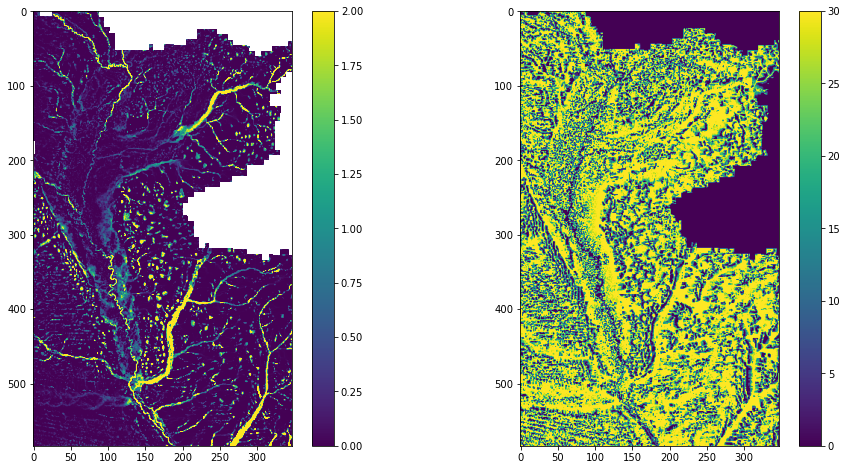

In [5]:

h = cbmi.get_value('LFP.H')
h += 1. # add one meter of water for testing purposes
cbmi.set_value('LFP.H', h)

cbmi.update(infiltcap=30./86400, storagecap=1e6)

h2 = cbmi.get_value('LFP.H')


# we added one meter of water so expect that this is returned after a second update.
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(h2, vmax=2.)
plt.colorbar()

plt.subplot(122)
plt.imshow(cbmi.bmimodels['LFP'].infilt)
plt.colorbar()


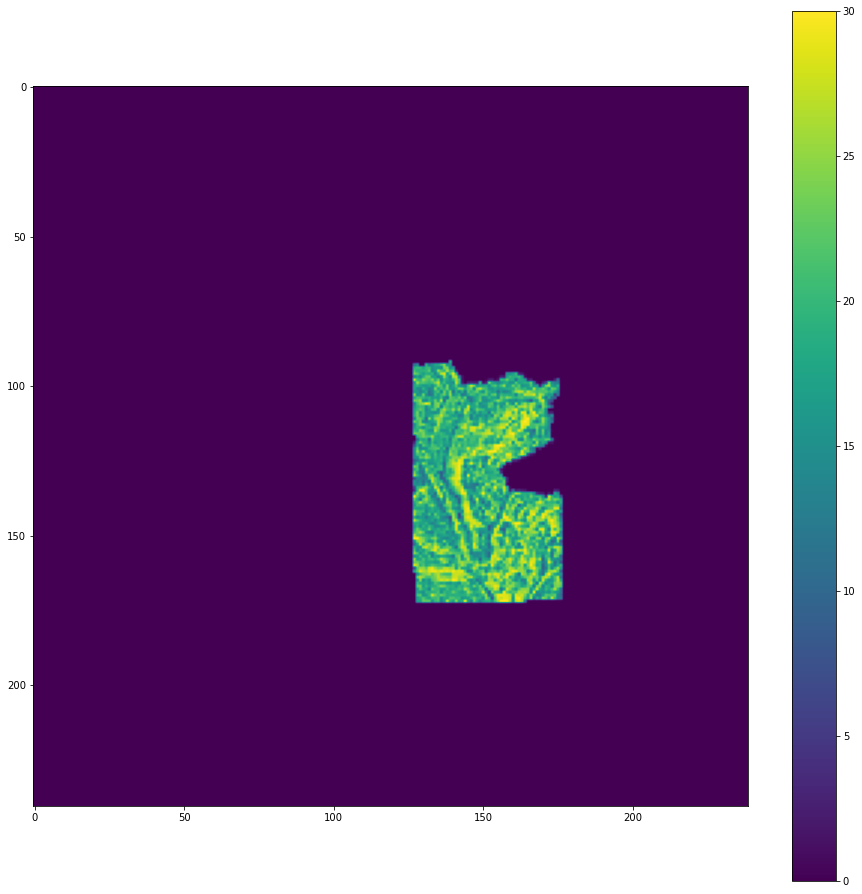

In [6]:
# check if retrieval and reprojection of infiltration works
infilt_wfl = reproject_lfp_wflow(cbmi.bmimodels['LFP'].infilt, np.nan)
infilt_wfl[np.isnan(infilt_wfl)] = 0.
plt.figure(figsize=(16, 16))
plt.imshow(infilt_wfl)
plt.colorbar()


In [7]:
# run test for 10 time steps
timesteps = 101
i = 0
zi = cbmi.bmimodels['WFL']._bmi.get_value('zi')

while i < timesteps:
    print(cbmi.get_current_time())
    # run wflow and lfp (inc. reinfiltration) for one step (assuming infiltration rate of 30./86400 mm per second)
    cbmi.update(infiltcap=30./86400, storagecap=1e6)
    # retrieve and reproject infiltration to wflow grid
    infilt_wfl = reproject_lfp_wflow(cbmi.bmimodels['LFP'].infilt, np.nan)
    # remove any missing values to prevent model crash
    infilt_wfl[np.isnan(infilt_wfl)] = 0.
    # add infiltrastion to snowwater store so that it will infiltrate into wflow in the next step
    _zi = zi
    zi = cbmi.bmimodels['WFL']._bmi.get_value('zi')
    diff = _zi - zi
    snow = cbmi.bmimodels['WFL']._bmi.get_value('Snow')
    snow += np.flipud(infilt_wfl)
    cbmi.bmimodels['WFL']._bmi.set_value('Snow', snow)
    i += 1



2020-06-05 17:55:59,749 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-02 00:00:00; LFP: 2000-10-02 00:00:14.739698


2000-10-02 00:00:00


2020-06-05 17:56:00,112 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:56:00,124 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-03 00:00
2020-06-05 17:56:00,124 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:56:00,127 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:56:19,129 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-03 00:00:12 in 3768 iterations
2020-06-05 17:56:19,130 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-03 00:00:00; LFP: 2000-10-03 00:00:12.532871
2020-06-05 17:56:19,147 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-03 00:00:00; LFP: 2000-10-03 00:00:12.532871


2000-10-03 00:00:00


2020-06-05 17:56:19,537 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:56:19,547 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-04 00:00
2020-06-05 17:56:19,548 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:56:19,551 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:56:36,868 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-04 00:00:05 in 3770 iterations
2020-06-05 17:56:36,869 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-04 00:00:00; LFP: 2000-10-04 00:00:05.394040
2020-06-05 17:56:36,883 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-04 00:00:00; LFP: 2000-10-04 00:00:05.394040


2000-10-04 00:00:00


2020-06-05 17:56:37,274 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:56:37,285 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-05 00:00
2020-06-05 17:56:37,286 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:56:37,289 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:56:53,871 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-05 00:00:12 in 3771 iterations
2020-06-05 17:56:53,873 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-05 00:00:00; LFP: 2000-10-05 00:00:12.420807
2020-06-05 17:56:53,892 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-05 00:00:00; LFP: 2000-10-05 00:00:12.420807


2000-10-05 00:00:00


2020-06-05 17:56:54,287 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:56:54,300 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-06 00:00
2020-06-05 17:56:54,300 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:56:54,303 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:57:10,479 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-06 00:00:22 in 3771 iterations
2020-06-05 17:57:10,480 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-06 00:00:00; LFP: 2000-10-06 00:00:22.807157
2020-06-05 17:57:10,493 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-06 00:00:00; LFP: 2000-10-06 00:00:22.807157


2000-10-06 00:00:00


2020-06-05 17:57:10,904 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:57:10,915 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-07 00:00
2020-06-05 17:57:10,915 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:57:10,918 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:57:26,890 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-07 00:00:17 in 3770 iterations
2020-06-05 17:57:26,891 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-07 00:00:00; LFP: 2000-10-07 00:00:17.964904
2020-06-05 17:57:26,905 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-07 00:00:00; LFP: 2000-10-07 00:00:17.964904


2000-10-07 00:00:00


2020-06-05 17:57:27,309 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:57:27,320 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-08 00:00
2020-06-05 17:57:27,320 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:57:27,323 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:57:42,759 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-08 00:00:20 in 3770 iterations
2020-06-05 17:57:42,760 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-08 00:00:00; LFP: 2000-10-08 00:00:20.151723
2020-06-05 17:57:42,774 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-08 00:00:00; LFP: 2000-10-08 00:00:20.151723


2000-10-08 00:00:00


2020-06-05 17:57:43,163 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:57:43,174 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-09 00:00
2020-06-05 17:57:43,175 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:57:43,178 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:57:58,454 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-09 00:00:04 in 3769 iterations
2020-06-05 17:57:58,455 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-09 00:00:00; LFP: 2000-10-09 00:00:04.404303
2020-06-05 17:57:58,468 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-09 00:00:00; LFP: 2000-10-09 00:00:04.404303


2000-10-09 00:00:00


2020-06-05 17:57:58,858 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:57:58,869 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-10 00:00
2020-06-05 17:57:58,869 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:57:58,873 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:58:14,082 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-10 00:00:18 in 3770 iterations
2020-06-05 17:58:14,083 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-10 00:00:00; LFP: 2000-10-10 00:00:18.564483
2020-06-05 17:58:14,097 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-10 00:00:00; LFP: 2000-10-10 00:00:18.564483


2000-10-10 00:00:00


2020-06-05 17:58:14,498 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:58:14,510 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-11 00:00
2020-06-05 17:58:14,510 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:58:14,513 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:58:29,245 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-11 00:00:19 in 3769 iterations
2020-06-05 17:58:29,246 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-11 00:00:00; LFP: 2000-10-11 00:00:19.435668
2020-06-05 17:58:29,264 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-11 00:00:00; LFP: 2000-10-11 00:00:19.435668


2000-10-11 00:00:00


2020-06-05 17:58:29,663 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:58:29,674 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-12 00:00
2020-06-05 17:58:29,674 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:58:29,677 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:58:44,101 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-12 00:00:07 in 3768 iterations
2020-06-05 17:58:44,102 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-12 00:00:00; LFP: 2000-10-12 00:00:07.109399
2020-06-05 17:58:44,116 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-12 00:00:00; LFP: 2000-10-12 00:00:07.109399


2000-10-12 00:00:00


2020-06-05 17:58:44,517 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:58:44,528 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-13 00:00
2020-06-05 17:58:44,529 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:58:44,531 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:58:58,900 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-13 00:00:04 in 3768 iterations
2020-06-05 17:58:58,901 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-13 00:00:00; LFP: 2000-10-13 00:00:04.464626
2020-06-05 17:58:58,915 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-13 00:00:00; LFP: 2000-10-13 00:00:04.464626


2000-10-13 00:00:00


2020-06-05 17:58:59,315 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:58:59,325 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-14 00:00
2020-06-05 17:58:59,326 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:58:59,328 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:59:13,606 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-14 00:00:11 in 3768 iterations
2020-06-05 17:59:13,607 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-14 00:00:00; LFP: 2000-10-14 00:00:11.442851
2020-06-05 17:59:13,626 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-14 00:00:00; LFP: 2000-10-14 00:00:11.442851


2000-10-14 00:00:00


2020-06-05 17:59:14,025 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:59:14,035 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-15 00:00
2020-06-05 17:59:14,036 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:59:14,038 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:59:28,311 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-15 00:00:03 in 3767 iterations
2020-06-05 17:59:28,313 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-15 00:00:00; LFP: 2000-10-15 00:00:03.517832
2020-06-05 17:59:28,332 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-15 00:00:00; LFP: 2000-10-15 00:00:03.517832


2000-10-15 00:00:00


2020-06-05 17:59:28,738 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:59:28,750 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-16 00:00
2020-06-05 17:59:28,751 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:59:28,753 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:59:42,799 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-16 00:00:04 in 3767 iterations
2020-06-05 17:59:42,800 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-16 00:00:00; LFP: 2000-10-16 00:00:04.068896
2020-06-05 17:59:42,814 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-16 00:00:00; LFP: 2000-10-16 00:00:04.068896


2000-10-16 00:00:00


2020-06-05 17:59:43,248 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:59:43,259 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-17 00:00
2020-06-05 17:59:43,259 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:59:43,262 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 17:59:57,304 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-17 00:00:14 in 3767 iterations
2020-06-05 17:59:57,305 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-17 00:00:00; LFP: 2000-10-17 00:00:14.050182
2020-06-05 17:59:57,320 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-17 00:00:00; LFP: 2000-10-17 00:00:14.050182


2000-10-17 00:00:00


2020-06-05 17:59:57,726 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 17:59:57,737 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-18 00:00
2020-06-05 17:59:57,738 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 17:59:57,740 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:00:11,803 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-18 00:00:09 in 3766 iterations
2020-06-05 18:00:11,804 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-18 00:00:00; LFP: 2000-10-18 00:00:09.370808
2020-06-05 18:00:11,818 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-18 00:00:00; LFP: 2000-10-18 00:00:09.370808


2000-10-18 00:00:00


2020-06-05 18:00:12,221 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:00:12,232 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-19 00:00
2020-06-05 18:00:12,232 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:00:12,235 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:00:26,384 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-19 00:00:13 in 3766 iterations
2020-06-05 18:00:26,385 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-19 00:00:00; LFP: 2000-10-19 00:00:13.836542
2020-06-05 18:00:26,398 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-19 00:00:00; LFP: 2000-10-19 00:00:13.836542


2000-10-19 00:00:00


2020-06-05 18:00:26,797 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:00:26,808 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-20 00:00
2020-06-05 18:00:26,808 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:00:26,811 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:00:40,805 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-20 00:00:04 in 3765 iterations
2020-06-05 18:00:40,806 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-20 00:00:00; LFP: 2000-10-20 00:00:04.666161
2020-06-05 18:00:40,820 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-20 00:00:00; LFP: 2000-10-20 00:00:04.666161


2000-10-20 00:00:00


2020-06-05 18:00:41,217 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:00:41,228 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-21 00:00
2020-06-05 18:00:41,228 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:00:41,231 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:00:55,259 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-21 00:00:04 in 3765 iterations
2020-06-05 18:00:55,260 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-21 00:00:00; LFP: 2000-10-21 00:00:04.814219
2020-06-05 18:00:55,277 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-21 00:00:00; LFP: 2000-10-21 00:00:04.814219


2000-10-21 00:00:00


2020-06-05 18:00:55,671 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:00:55,683 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-22 00:00
2020-06-05 18:00:55,684 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:00:55,687 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:01:09,791 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-22 00:00:14 in 3765 iterations
2020-06-05 18:01:09,792 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-22 00:00:00; LFP: 2000-10-22 00:00:14.240378
2020-06-05 18:01:09,806 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-22 00:00:00; LFP: 2000-10-22 00:00:14.240378


2000-10-22 00:00:00


2020-06-05 18:01:10,208 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:01:10,219 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-23 00:00
2020-06-05 18:01:10,220 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:01:10,223 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:01:24,595 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-23 00:00:09 in 3764 iterations
2020-06-05 18:01:24,596 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-23 00:00:00; LFP: 2000-10-23 00:00:09.943629
2020-06-05 18:01:24,609 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-23 00:00:00; LFP: 2000-10-23 00:00:09.943629


2000-10-23 00:00:00


2020-06-05 18:01:24,990 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:01:24,999 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-24 00:00
2020-06-05 18:01:25,000 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:01:25,002 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:01:38,094 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-24 00:00:14 in 3764 iterations
2020-06-05 18:01:38,095 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-24 00:00:00; LFP: 2000-10-24 00:00:14.817170
2020-06-05 18:01:38,108 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-24 00:00:00; LFP: 2000-10-24 00:00:14.817170


2000-10-24 00:00:00


2020-06-05 18:01:38,499 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:01:38,510 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-25 00:00
2020-06-05 18:01:38,510 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:01:38,513 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:01:51,604 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-25 00:00:05 in 3763 iterations
2020-06-05 18:01:51,605 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-25 00:00:00; LFP: 2000-10-25 00:00:05.859637
2020-06-05 18:01:51,620 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-25 00:00:00; LFP: 2000-10-25 00:00:05.859637


2000-10-25 00:00:00


2020-06-05 18:01:52,017 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:01:52,028 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-26 00:00
2020-06-05 18:01:52,029 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:01:52,031 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:02:04,974 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-26 00:00:05 in 3763 iterations
2020-06-05 18:02:04,975 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-26 00:00:00; LFP: 2000-10-26 00:00:05.921359
2020-06-05 18:02:04,993 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-26 00:00:00; LFP: 2000-10-26 00:00:05.921359


2000-10-26 00:00:00


2020-06-05 18:02:05,415 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:02:05,425 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-27 00:00
2020-06-05 18:02:05,425 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:02:05,428 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:02:18,321 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-27 00:00:14 in 3763 iterations
2020-06-05 18:02:18,322 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-27 00:00:00; LFP: 2000-10-27 00:00:14.293055
2020-06-05 18:02:18,341 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-27 00:00:00; LFP: 2000-10-27 00:00:14.293055


2000-10-27 00:00:00


2020-06-05 18:02:18,736 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:02:18,746 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-28 00:00
2020-06-05 18:02:18,747 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:02:18,749 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:02:31,626 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-28 00:00:08 in 3762 iterations
2020-06-05 18:02:31,627 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-28 00:00:00; LFP: 2000-10-28 00:00:08.343548
2020-06-05 18:02:31,644 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-28 00:00:00; LFP: 2000-10-28 00:00:08.343548


2000-10-28 00:00:00


2020-06-05 18:02:32,041 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:02:32,051 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-29 00:00
2020-06-05 18:02:32,052 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:02:32,054 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:02:44,720 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-29 00:00:11 in 3762 iterations
2020-06-05 18:02:44,721 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-29 00:00:00; LFP: 2000-10-29 00:00:11.311541
2020-06-05 18:02:44,735 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-29 00:00:00; LFP: 2000-10-29 00:00:11.311541


2000-10-29 00:00:00


2020-06-05 18:02:45,132 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:02:45,142 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-30 00:00
2020-06-05 18:02:45,143 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:02:45,146 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:02:57,788 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-30 00:00:22 in 3762 iterations
2020-06-05 18:02:57,789 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-30 00:00:00; LFP: 2000-10-30 00:00:22.206961
2020-06-05 18:02:57,804 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-30 00:00:00; LFP: 2000-10-30 00:00:22.206961


2000-10-30 00:00:00


2020-06-05 18:02:58,198 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:02:58,209 - GLOFRIM.WFL - INFO - updated model to datetime 2000-10-31 00:00
2020-06-05 18:02:58,210 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:02:58,213 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:03:10,909 - GLOFRIM.LFP - INFO - updated model to datetime 2000-10-31 00:00:16 in 3761 iterations
2020-06-05 18:03:10,910 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-31 00:00:00; LFP: 2000-10-31 00:00:16.804005
2020-06-05 18:03:10,924 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-10-31 00:00:00; LFP: 2000-10-31 00:00:16.804005


2000-10-31 00:00:00


2020-06-05 18:03:11,321 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:03:11,332 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-01 00:00
2020-06-05 18:03:11,332 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:03:11,335 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:03:24,151 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-01 00:00:18 in 3761 iterations
2020-06-05 18:03:24,152 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-01 00:00:00; LFP: 2000-11-01 00:00:18.088080
2020-06-05 18:03:24,165 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-01 00:00:00; LFP: 2000-11-01 00:00:18.088080


2000-11-01 00:00:00


2020-06-05 18:03:24,567 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:03:24,577 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-02 00:00
2020-06-05 18:03:24,577 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:03:24,580 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:03:37,218 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-02 00:00:04 in 3760 iterations
2020-06-05 18:03:37,219 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-02 00:00:00; LFP: 2000-11-02 00:00:04.115778
2020-06-05 18:03:37,233 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-02 00:00:00; LFP: 2000-11-02 00:00:04.115778


2000-11-02 00:00:00


2020-06-05 18:03:37,628 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:03:37,638 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-03 00:00
2020-06-05 18:03:37,639 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:03:37,641 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:03:50,252 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-03 00:00:21 in 3761 iterations
2020-06-05 18:03:50,253 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-03 00:00:00; LFP: 2000-11-03 00:00:21.692676
2020-06-05 18:03:50,267 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-03 00:00:00; LFP: 2000-11-03 00:00:21.692676


2000-11-03 00:00:00


2020-06-05 18:03:50,662 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:03:50,673 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-04 00:00
2020-06-05 18:03:50,674 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:03:50,676 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:04:03,275 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-04 00:00:00 in 3759 iterations
2020-06-05 18:04:03,276 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-04 00:00:00; LFP: 2000-11-04 00:00:00.968388
2020-06-05 18:04:03,290 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-04 00:00:00; LFP: 2000-11-04 00:00:00.968388


2000-11-04 00:00:00


2020-06-05 18:04:03,691 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:04:03,701 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-05 00:00
2020-06-05 18:04:03,702 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:04:03,704 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:04:16,364 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-05 00:00:10 in 3760 iterations
2020-06-05 18:04:16,365 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-05 00:00:00; LFP: 2000-11-05 00:00:10.324724
2020-06-05 18:04:16,378 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-05 00:00:00; LFP: 2000-11-05 00:00:10.324724


2000-11-05 00:00:00


2020-06-05 18:04:16,804 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:04:16,815 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-06 00:00
2020-06-05 18:04:16,816 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:04:16,819 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:04:29,392 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-06 00:00:03 in 3759 iterations
2020-06-05 18:04:29,393 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-06 00:00:00; LFP: 2000-11-06 00:00:03.499220
2020-06-05 18:04:29,410 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-06 00:00:00; LFP: 2000-11-06 00:00:03.499220


2000-11-06 00:00:00


2020-06-05 18:04:29,810 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:04:29,821 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-07 00:00
2020-06-05 18:04:29,821 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:04:29,824 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:04:42,326 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-07 00:00:04 in 3759 iterations
2020-06-05 18:04:42,327 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-07 00:00:00; LFP: 2000-11-07 00:00:04.003560
2020-06-05 18:04:42,344 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-07 00:00:00; LFP: 2000-11-07 00:00:04.003560


2000-11-07 00:00:00


2020-06-05 18:04:42,746 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:04:42,757 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-08 00:00
2020-06-05 18:04:42,757 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:04:42,760 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:04:55,356 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-08 00:00:12 in 3759 iterations
2020-06-05 18:04:55,357 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-08 00:00:00; LFP: 2000-11-08 00:00:12.160006
2020-06-05 18:04:55,381 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-08 00:00:00; LFP: 2000-11-08 00:00:12.160006


2000-11-08 00:00:00


2020-06-05 18:04:55,789 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:04:55,800 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-09 00:00
2020-06-05 18:04:55,800 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:04:55,803 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:05:08,424 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-09 00:00:04 in 3758 iterations
2020-06-05 18:05:08,425 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-09 00:00:00; LFP: 2000-11-09 00:00:04.093831
2020-06-05 18:05:08,440 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-09 00:00:00; LFP: 2000-11-09 00:00:04.093831


2000-11-09 00:00:00


2020-06-05 18:05:08,843 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:05:08,854 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-10 00:00
2020-06-05 18:05:08,855 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:05:08,858 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:05:21,541 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-10 00:00:02 in 3758 iterations
2020-06-05 18:05:21,542 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-10 00:00:00; LFP: 2000-11-10 00:00:02.038097
2020-06-05 18:05:21,556 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-10 00:00:00; LFP: 2000-11-10 00:00:02.038097


2000-11-10 00:00:00


2020-06-05 18:05:21,958 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:05:21,970 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-11 00:00
2020-06-05 18:05:21,970 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:05:21,973 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:05:34,826 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-11 00:00:05 in 3758 iterations
2020-06-05 18:05:34,827 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-11 00:00:00; LFP: 2000-11-11 00:00:05.660440
2020-06-05 18:05:34,841 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-11 00:00:00; LFP: 2000-11-11 00:00:05.660440


2000-11-11 00:00:00


2020-06-05 18:05:35,243 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:05:35,253 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-12 00:00
2020-06-05 18:05:35,254 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:05:35,257 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:05:47,763 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-12 00:00:16 in 3758 iterations
2020-06-05 18:05:47,764 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-12 00:00:00; LFP: 2000-11-12 00:00:16.851974
2020-06-05 18:05:47,778 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-12 00:00:00; LFP: 2000-11-12 00:00:16.851974


2000-11-12 00:00:00


2020-06-05 18:05:48,199 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:05:48,212 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-13 00:00
2020-06-05 18:05:48,213 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:05:48,216 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:06:00,673 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-13 00:00:11 in 3757 iterations
2020-06-05 18:06:00,674 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-13 00:00:00; LFP: 2000-11-13 00:00:11.947385
2020-06-05 18:06:00,687 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-13 00:00:00; LFP: 2000-11-13 00:00:11.947385


2000-11-13 00:00:00


2020-06-05 18:06:01,109 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:06:01,119 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-14 00:00
2020-06-05 18:06:01,119 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:06:01,122 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:06:13,666 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-14 00:00:13 in 3757 iterations
2020-06-05 18:06:13,667 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-14 00:00:00; LFP: 2000-11-14 00:00:13.591531
2020-06-05 18:06:13,681 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-14 00:00:00; LFP: 2000-11-14 00:00:13.591531


2000-11-14 00:00:00


2020-06-05 18:06:14,103 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:06:14,114 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-15 00:00
2020-06-05 18:06:14,115 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:06:14,117 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:06:26,602 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-15 00:00:21 in 3757 iterations
2020-06-05 18:06:26,603 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-15 00:00:00; LFP: 2000-11-15 00:00:21.439621
2020-06-05 18:06:26,617 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-15 00:00:00; LFP: 2000-11-15 00:00:21.439621


2000-11-15 00:00:00


2020-06-05 18:06:27,066 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:06:27,077 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-16 00:00
2020-06-05 18:06:27,077 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:06:27,080 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:06:39,543 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-16 00:00:12 in 3756 iterations
2020-06-05 18:06:39,544 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-16 00:00:00; LFP: 2000-11-16 00:00:12.804054
2020-06-05 18:06:39,558 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-16 00:00:00; LFP: 2000-11-16 00:00:12.804054


2000-11-16 00:00:00


2020-06-05 18:06:39,980 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:06:39,990 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-17 00:00
2020-06-05 18:06:39,991 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:06:39,994 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:06:52,466 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-17 00:00:11 in 3756 iterations
2020-06-05 18:06:52,467 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-17 00:00:00; LFP: 2000-11-17 00:00:11.189552
2020-06-05 18:06:52,480 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-17 00:00:00; LFP: 2000-11-17 00:00:11.189552


2000-11-17 00:00:00


2020-06-05 18:06:52,898 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:06:52,909 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-18 00:00
2020-06-05 18:06:52,910 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:06:52,912 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:07:05,483 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-18 00:00:17 in 3756 iterations
2020-06-05 18:07:05,484 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-18 00:00:00; LFP: 2000-11-18 00:00:17.716797
2020-06-05 18:07:05,498 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-18 00:00:00; LFP: 2000-11-18 00:00:17.716797


2000-11-18 00:00:00


2020-06-05 18:07:05,902 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:07:05,912 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-19 00:00
2020-06-05 18:07:05,913 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:07:05,916 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:07:18,503 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-19 00:00:09 in 3755 iterations
2020-06-05 18:07:18,504 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-19 00:00:00; LFP: 2000-11-19 00:00:09.465870
2020-06-05 18:07:18,519 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-19 00:00:00; LFP: 2000-11-19 00:00:09.465870


2000-11-19 00:00:00


2020-06-05 18:07:18,921 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:07:18,932 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-20 00:00
2020-06-05 18:07:18,932 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:07:18,935 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:07:31,628 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-20 00:00:08 in 3755 iterations
2020-06-05 18:07:31,629 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-20 00:00:00; LFP: 2000-11-20 00:00:08.839747
2020-06-05 18:07:31,642 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-20 00:00:00; LFP: 2000-11-20 00:00:08.839747


2000-11-20 00:00:00


2020-06-05 18:07:32,046 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:07:32,057 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-21 00:00
2020-06-05 18:07:32,058 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:07:32,060 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:07:44,576 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-21 00:00:16 in 3755 iterations
2020-06-05 18:07:44,577 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-21 00:00:00; LFP: 2000-11-21 00:00:16.282258
2020-06-05 18:07:44,603 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-21 00:00:00; LFP: 2000-11-21 00:00:16.282258


2000-11-21 00:00:00


2020-06-05 18:07:45,024 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:07:45,035 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-22 00:00
2020-06-05 18:07:45,036 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:07:45,039 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:07:57,424 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-22 00:00:08 in 3754 iterations
2020-06-05 18:07:57,425 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-22 00:00:00; LFP: 2000-11-22 00:00:08.400809
2020-06-05 18:07:57,439 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-22 00:00:00; LFP: 2000-11-22 00:00:08.400809


2000-11-22 00:00:00


2020-06-05 18:07:57,839 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:07:57,850 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-23 00:00
2020-06-05 18:07:57,851 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:07:57,853 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:08:10,512 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-23 00:00:06 in 3754 iterations
2020-06-05 18:08:10,513 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-23 00:00:00; LFP: 2000-11-23 00:00:06.675916
2020-06-05 18:08:10,528 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-23 00:00:00; LFP: 2000-11-23 00:00:06.675916


2000-11-23 00:00:00


2020-06-05 18:08:10,927 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:08:10,938 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-24 00:00
2020-06-05 18:08:10,939 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:08:10,941 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:08:23,512 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-24 00:00:12 in 3754 iterations
2020-06-05 18:08:23,513 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-24 00:00:00; LFP: 2000-11-24 00:00:12.682947
2020-06-05 18:08:23,527 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-24 00:00:00; LFP: 2000-11-24 00:00:12.682947


2000-11-24 00:00:00


2020-06-05 18:08:23,924 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:08:23,935 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-25 00:00
2020-06-05 18:08:23,936 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:08:23,939 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:08:36,359 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-25 00:00:03 in 3753 iterations
2020-06-05 18:08:36,360 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-25 00:00:00; LFP: 2000-11-25 00:00:03.472437
2020-06-05 18:08:36,374 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-25 00:00:00; LFP: 2000-11-25 00:00:03.472437


2000-11-25 00:00:00


2020-06-05 18:08:36,805 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:08:36,816 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-26 00:00
2020-06-05 18:08:36,817 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:08:36,819 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:08:49,301 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-26 00:00:01 in 3753 iterations
2020-06-05 18:08:49,302 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-26 00:00:00; LFP: 2000-11-26 00:00:01.163974
2020-06-05 18:08:49,316 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-26 00:00:00; LFP: 2000-11-26 00:00:01.163974


2000-11-26 00:00:00


2020-06-05 18:08:49,737 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:08:49,748 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-27 00:00
2020-06-05 18:08:49,748 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:08:49,751 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:09:02,252 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-27 00:00:06 in 3753 iterations
2020-06-05 18:09:02,253 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-27 00:00:00; LFP: 2000-11-27 00:00:06.783432
2020-06-05 18:09:02,267 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-27 00:00:00; LFP: 2000-11-27 00:00:06.783432


2000-11-27 00:00:00


2020-06-05 18:09:02,686 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:09:02,697 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-28 00:00
2020-06-05 18:09:02,697 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:09:02,700 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:09:15,215 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-28 00:00:19 in 3753 iterations
2020-06-05 18:09:15,216 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-28 00:00:00; LFP: 2000-11-28 00:00:19.401247
2020-06-05 18:09:15,229 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-28 00:00:00; LFP: 2000-11-28 00:00:19.401247


2000-11-28 00:00:00


2020-06-05 18:09:15,651 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:09:15,662 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-29 00:00
2020-06-05 18:09:15,662 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:09:15,665 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:09:28,303 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-29 00:00:16 in 3752 iterations
2020-06-05 18:09:28,304 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-29 00:00:00; LFP: 2000-11-29 00:00:16.349281
2020-06-05 18:09:28,317 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-29 00:00:00; LFP: 2000-11-29 00:00:16.349281


2000-11-29 00:00:00


2020-06-05 18:09:28,739 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:09:28,750 - GLOFRIM.WFL - INFO - updated model to datetime 2000-11-30 00:00
2020-06-05 18:09:28,750 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:09:28,753 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:09:41,176 - GLOFRIM.LFP - INFO - updated model to datetime 2000-11-30 00:00:21 in 3752 iterations
2020-06-05 18:09:41,177 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-30 00:00:00; LFP: 2000-11-30 00:00:21.174331
2020-06-05 18:09:41,191 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-11-30 00:00:00; LFP: 2000-11-30 00:00:21.174331


2000-11-30 00:00:00


2020-06-05 18:09:41,616 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:09:41,627 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-01 00:00
2020-06-05 18:09:41,627 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:09:41,630 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:09:53,987 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-01 00:00:10 in 3751 iterations
2020-06-05 18:09:53,988 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-01 00:00:00; LFP: 2000-12-01 00:00:10.812900
2020-06-05 18:09:54,004 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-01 00:00:00; LFP: 2000-12-01 00:00:10.812900


2000-12-01 00:00:00


2020-06-05 18:09:54,438 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:09:54,449 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-02 00:00
2020-06-05 18:09:54,450 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:09:54,452 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:10:06,847 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-02 00:00:08 in 3751 iterations
2020-06-05 18:10:06,848 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-02 00:00:00; LFP: 2000-12-02 00:00:08.267899
2020-06-05 18:10:06,862 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-02 00:00:00; LFP: 2000-12-02 00:00:08.267899


2000-12-02 00:00:00


2020-06-05 18:10:07,295 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:10:07,306 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-03 00:00
2020-06-05 18:10:07,306 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:10:07,309 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:10:19,675 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-03 00:00:13 in 3751 iterations
2020-06-05 18:10:19,676 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-03 00:00:00; LFP: 2000-12-03 00:00:13.530981
2020-06-05 18:10:19,691 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-03 00:00:00; LFP: 2000-12-03 00:00:13.530981


2000-12-03 00:00:00


2020-06-05 18:10:20,124 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:10:20,134 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-04 00:00
2020-06-05 18:10:20,135 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:10:20,137 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:10:32,976 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-04 00:00:03 in 3750 iterations
2020-06-05 18:10:32,976 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-04 00:00:00; LFP: 2000-12-04 00:00:03.567798
2020-06-05 18:10:33,005 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-04 00:00:00; LFP: 2000-12-04 00:00:03.567798


2000-12-04 00:00:00


2020-06-05 18:10:33,443 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:10:33,453 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-05 00:00
2020-06-05 18:10:33,454 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:10:33,456 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:10:45,821 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-05 00:00:01 in 3750 iterations
2020-06-05 18:10:45,822 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-05 00:00:00; LFP: 2000-12-05 00:00:01.409439
2020-06-05 18:10:45,836 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-05 00:00:00; LFP: 2000-12-05 00:00:01.409439


2000-12-05 00:00:00


2020-06-05 18:10:46,301 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:10:46,312 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-06 00:00
2020-06-05 18:10:46,312 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:10:46,315 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:10:58,723 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-06 00:00:07 in 3750 iterations
2020-06-05 18:10:58,724 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-06 00:00:00; LFP: 2000-12-06 00:00:07.050246
2020-06-05 18:10:58,745 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-06 00:00:00; LFP: 2000-12-06 00:00:07.050246


2000-12-06 00:00:00


2020-06-05 18:10:59,182 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:10:59,192 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-07 00:00
2020-06-05 18:10:59,193 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:10:59,195 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:11:11,689 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-07 00:00:20 in 3750 iterations
2020-06-05 18:11:11,690 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-07 00:00:00; LFP: 2000-12-07 00:00:20.228878
2020-06-05 18:11:11,717 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-07 00:00:00; LFP: 2000-12-07 00:00:20.228878


2000-12-07 00:00:00


2020-06-05 18:11:12,150 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:11:12,163 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-08 00:00
2020-06-05 18:11:12,164 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:11:12,167 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:11:24,739 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-08 00:00:17 in 3749 iterations
2020-06-05 18:11:24,740 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-08 00:00:00; LFP: 2000-12-08 00:00:17.597596
2020-06-05 18:11:24,753 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-08 00:00:00; LFP: 2000-12-08 00:00:17.597596


2000-12-08 00:00:00


2020-06-05 18:11:25,179 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:11:25,188 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-09 00:00
2020-06-05 18:11:25,189 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:11:25,192 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:11:37,631 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-09 00:00:22 in 3749 iterations
2020-06-05 18:11:37,632 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-09 00:00:00; LFP: 2000-12-09 00:00:22.612932
2020-06-05 18:11:37,646 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-09 00:00:00; LFP: 2000-12-09 00:00:22.612932


2000-12-09 00:00:00


2020-06-05 18:11:38,078 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:11:38,088 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-10 00:00
2020-06-05 18:11:38,089 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:11:38,092 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:11:50,520 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-10 00:00:12 in 3748 iterations
2020-06-05 18:11:50,521 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-10 00:00:00; LFP: 2000-12-10 00:00:12.171329
2020-06-05 18:11:50,535 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-10 00:00:00; LFP: 2000-12-10 00:00:12.171329


2000-12-10 00:00:00


2020-06-05 18:11:50,966 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:11:50,977 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-11 00:00
2020-06-05 18:11:50,978 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:11:50,981 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:12:03,385 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-11 00:00:09 in 3748 iterations
2020-06-05 18:12:03,387 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-11 00:00:00; LFP: 2000-12-11 00:00:09.482538
2020-06-05 18:12:03,401 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-11 00:00:00; LFP: 2000-12-11 00:00:09.482538


2000-12-11 00:00:00


2020-06-05 18:12:03,834 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:12:03,845 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-12 00:00
2020-06-05 18:12:03,845 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:12:03,848 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:12:16,267 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-12 00:00:14 in 3748 iterations
2020-06-05 18:12:16,268 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-12 00:00:00; LFP: 2000-12-12 00:00:14.508262
2020-06-05 18:12:16,282 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-12 00:00:00; LFP: 2000-12-12 00:00:14.508262


2000-12-12 00:00:00


2020-06-05 18:12:16,716 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:12:16,727 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-13 00:00
2020-06-05 18:12:16,728 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:12:16,731 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:12:29,190 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-13 00:00:03 in 3747 iterations
2020-06-05 18:12:29,191 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-13 00:00:00; LFP: 2000-12-13 00:00:03.048194
2020-06-05 18:12:29,209 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-13 00:00:00; LFP: 2000-12-13 00:00:03.048194


2000-12-13 00:00:00


2020-06-05 18:12:29,643 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:12:29,653 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-14 00:00
2020-06-05 18:12:29,654 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:12:29,657 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:12:42,044 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-14 00:00:22 in 3748 iterations
2020-06-05 18:12:42,045 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-14 00:00:00; LFP: 2000-12-14 00:00:22.255907
2020-06-05 18:12:42,059 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-14 00:00:00; LFP: 2000-12-14 00:00:22.255907


2000-12-14 00:00:00


2020-06-05 18:12:42,493 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:12:42,503 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-15 00:00
2020-06-05 18:12:42,504 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:12:42,507 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:12:54,868 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-15 00:00:03 in 3746 iterations
2020-06-05 18:12:54,869 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-15 00:00:00; LFP: 2000-12-15 00:00:03.084191
2020-06-05 18:12:54,884 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-15 00:00:00; LFP: 2000-12-15 00:00:03.084191


2000-12-15 00:00:00


2020-06-05 18:12:55,354 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:12:55,365 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-16 00:00
2020-06-05 18:12:55,366 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:12:55,369 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:13:07,819 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-16 00:00:14 in 3747 iterations
2020-06-05 18:13:07,820 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-16 00:00:00; LFP: 2000-12-16 00:00:14.582812
2020-06-05 18:13:07,834 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-16 00:00:00; LFP: 2000-12-16 00:00:14.582812


2000-12-16 00:00:00


2020-06-05 18:13:08,270 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:13:08,280 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-17 00:00
2020-06-05 18:13:08,281 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:13:08,283 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:13:20,768 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-17 00:00:10 in 3746 iterations
2020-06-05 18:13:20,769 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-17 00:00:00; LFP: 2000-12-17 00:00:10.752826
2020-06-05 18:13:20,784 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-17 00:00:00; LFP: 2000-12-17 00:00:10.752826


2000-12-17 00:00:00


2020-06-05 18:13:21,219 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:13:21,230 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-18 00:00
2020-06-05 18:13:21,231 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:13:21,234 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:13:33,844 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-18 00:00:14 in 3746 iterations
2020-06-05 18:13:33,845 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-18 00:00:00; LFP: 2000-12-18 00:00:14.665603
2020-06-05 18:13:33,860 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-18 00:00:00; LFP: 2000-12-18 00:00:14.665603


2000-12-18 00:00:00


2020-06-05 18:13:34,299 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:13:34,309 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-19 00:00
2020-06-05 18:13:34,310 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:13:34,312 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:13:46,713 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-19 00:00:03 in 3745 iterations
2020-06-05 18:13:46,714 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-19 00:00:00; LFP: 2000-12-19 00:00:03.257185
2020-06-05 18:13:46,728 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-19 00:00:00; LFP: 2000-12-19 00:00:03.257185


2000-12-19 00:00:00


2020-06-05 18:13:47,166 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:13:47,178 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-20 00:00
2020-06-05 18:13:47,178 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:13:47,181 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:13:59,590 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-20 00:00:22 in 3746 iterations
2020-06-05 18:13:59,591 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-20 00:00:00; LFP: 2000-12-20 00:00:22.282250
2020-06-05 18:13:59,605 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-20 00:00:00; LFP: 2000-12-20 00:00:22.282250


2000-12-20 00:00:00


2020-06-05 18:14:00,047 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:14:00,058 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-21 00:00
2020-06-05 18:14:00,058 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:14:00,061 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:14:12,766 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-21 00:00:01 in 3744 iterations
2020-06-05 18:14:12,767 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-21 00:00:00; LFP: 2000-12-21 00:00:01.224245
2020-06-05 18:14:12,781 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-21 00:00:00; LFP: 2000-12-21 00:00:01.224245


2000-12-21 00:00:00


2020-06-05 18:14:13,226 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:14:13,237 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-22 00:00
2020-06-05 18:14:13,238 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:14:13,240 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:14:25,773 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-22 00:00:08 in 3745 iterations
2020-06-05 18:14:25,774 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-22 00:00:00; LFP: 2000-12-22 00:00:08.406347
2020-06-05 18:14:25,793 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-22 00:00:00; LFP: 2000-12-22 00:00:08.406347


2000-12-22 00:00:00


2020-06-05 18:14:26,238 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:14:26,248 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-23 00:00
2020-06-05 18:14:26,249 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:14:26,252 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:14:38,759 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-23 00:00:20 in 3745 iterations
2020-06-05 18:14:38,760 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-23 00:00:00; LFP: 2000-12-23 00:00:20.708333
2020-06-05 18:14:38,775 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-23 00:00:00; LFP: 2000-12-23 00:00:20.708333


2000-12-23 00:00:00


2020-06-05 18:14:39,221 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:14:39,231 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-24 00:00
2020-06-05 18:14:39,232 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:14:39,235 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:14:51,726 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-24 00:00:14 in 3744 iterations
2020-06-05 18:14:51,727 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-24 00:00:00; LFP: 2000-12-24 00:00:14.987400
2020-06-05 18:14:51,742 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-24 00:00:00; LFP: 2000-12-24 00:00:14.987400


2000-12-24 00:00:00


2020-06-05 18:14:52,259 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:14:52,270 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-25 00:00
2020-06-05 18:14:52,271 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:14:52,274 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:15:04,764 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-25 00:00:14 in 3744 iterations
2020-06-05 18:15:04,765 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-25 00:00:00; LFP: 2000-12-25 00:00:14.816583
2020-06-05 18:15:04,779 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-25 00:00:00; LFP: 2000-12-25 00:00:14.816583


2000-12-25 00:00:00


2020-06-05 18:15:05,245 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:15:05,256 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-26 00:00
2020-06-05 18:15:05,257 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:15:05,260 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:15:17,740 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-26 00:00:21 in 3744 iterations
2020-06-05 18:15:17,741 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-26 00:00:00; LFP: 2000-12-26 00:00:21.670938
2020-06-05 18:15:17,759 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-26 00:00:00; LFP: 2000-12-26 00:00:21.670938


2000-12-26 00:00:00


2020-06-05 18:15:18,199 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:15:18,209 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-27 00:00
2020-06-05 18:15:18,210 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:15:18,213 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:15:31,734 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-27 00:00:12 in 3743 iterations
2020-06-05 18:15:31,735 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-27 00:00:00; LFP: 2000-12-27 00:00:12.819255
2020-06-05 18:15:31,748 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-27 00:00:00; LFP: 2000-12-27 00:00:12.819255


2000-12-27 00:00:00


2020-06-05 18:15:32,188 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:15:32,198 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-28 00:00
2020-06-05 18:15:32,199 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:15:32,202 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:15:44,614 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-28 00:00:11 in 3743 iterations
2020-06-05 18:15:44,615 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-28 00:00:00; LFP: 2000-12-28 00:00:11.553739
2020-06-05 18:15:44,629 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-28 00:00:00; LFP: 2000-12-28 00:00:11.553739


2000-12-28 00:00:00


2020-06-05 18:15:45,075 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:15:45,086 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-29 00:00
2020-06-05 18:15:45,087 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:15:45,089 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:15:57,860 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-29 00:00:17 in 3743 iterations
2020-06-05 18:15:57,861 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-29 00:00:00; LFP: 2000-12-29 00:00:17.668136
2020-06-05 18:15:57,877 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-29 00:00:00; LFP: 2000-12-29 00:00:17.668136


2000-12-29 00:00:00


2020-06-05 18:15:58,320 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:15:58,330 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-30 00:00
2020-06-05 18:15:58,331 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:15:58,335 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:16:10,939 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-30 00:00:08 in 3742 iterations
2020-06-05 18:16:10,940 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-30 00:00:00; LFP: 2000-12-30 00:00:08.363914
2020-06-05 18:16:10,954 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-30 00:00:00; LFP: 2000-12-30 00:00:08.363914


2000-12-30 00:00:00


2020-06-05 18:16:11,417 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:16:11,427 - GLOFRIM.WFL - INFO - updated model to datetime 2000-12-31 00:00
2020-06-05 18:16:11,428 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:16:11,431 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:16:23,932 - GLOFRIM.LFP - INFO - updated model to datetime 2000-12-31 00:00:06 in 3742 iterations
2020-06-05 18:16:23,933 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-31 00:00:00; LFP: 2000-12-31 00:00:06.355930
2020-06-05 18:16:23,947 - GLOFRIM - WARNING - Model times out of sync: WFL: 2000-12-31 00:00:00; LFP: 2000-12-31 00:00:06.355930


2000-12-31 00:00:00


2020-06-05 18:16:24,391 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:16:24,401 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-01 00:00
2020-06-05 18:16:24,402 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:16:24,405 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:16:36,855 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-01 00:00:11 in 3742 iterations
2020-06-05 18:16:36,856 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-01 00:00:00; LFP: 2001-01-01 00:00:11.982627
2020-06-05 18:16:36,875 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-01 00:00:00; LFP: 2001-01-01 00:00:11.982627


2001-01-01 00:00:00


2020-06-05 18:16:37,314 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:16:37,323 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-02 00:00
2020-06-05 18:16:37,324 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:16:37,327 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:16:49,724 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-02 00:00:01 in 3741 iterations
2020-06-05 18:16:49,725 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-02 00:00:00; LFP: 2001-01-02 00:00:01.746569
2020-06-05 18:16:49,739 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-02 00:00:00; LFP: 2001-01-02 00:00:01.746569


2001-01-02 00:00:00


2020-06-05 18:16:50,184 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:16:50,196 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-03 00:00
2020-06-05 18:16:50,197 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:16:50,200 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:17:02,554 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-03 00:00:22 in 3742 iterations
2020-06-05 18:17:02,555 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-03 00:00:00; LFP: 2001-01-03 00:00:22.181905
2020-06-05 18:17:02,570 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-03 00:00:00; LFP: 2001-01-03 00:00:22.181905


2001-01-03 00:00:00


2020-06-05 18:17:03,015 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:17:03,025 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-04 00:00
2020-06-05 18:17:03,026 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:17:03,029 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:17:15,526 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-04 00:00:04 in 3740 iterations
2020-06-05 18:17:15,527 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-04 00:00:00; LFP: 2001-01-04 00:00:04.099495
2020-06-05 18:17:15,543 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-04 00:00:00; LFP: 2001-01-04 00:00:04.099495


2001-01-04 00:00:00


2020-06-05 18:17:16,027 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:17:16,037 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-05 00:00
2020-06-05 18:17:16,038 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:17:16,041 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:17:28,682 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-05 00:00:16 in 3741 iterations
2020-06-05 18:17:28,683 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-05 00:00:00; LFP: 2001-01-05 00:00:16.700354
2020-06-05 18:17:28,696 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-05 00:00:00; LFP: 2001-01-05 00:00:16.700354


2001-01-05 00:00:00


2020-06-05 18:17:29,141 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:17:29,152 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-06 00:00
2020-06-05 18:17:29,152 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:17:29,156 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:17:41,562 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-06 00:00:12 in 3740 iterations
2020-06-05 18:17:41,563 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-06 00:00:00; LFP: 2001-01-06 00:00:12.559364
2020-06-05 18:17:41,577 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-06 00:00:00; LFP: 2001-01-06 00:00:12.559364


2001-01-06 00:00:00


2020-06-05 18:17:42,026 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:17:42,037 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-07 00:00
2020-06-05 18:17:42,038 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:17:42,040 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:17:54,371 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-07 00:00:15 in 3740 iterations
2020-06-05 18:17:54,372 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-07 00:00:00; LFP: 2001-01-07 00:00:15.842714
2020-06-05 18:17:54,386 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-07 00:00:00; LFP: 2001-01-07 00:00:15.842714


2001-01-07 00:00:00


2020-06-05 18:17:54,835 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:17:54,845 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-08 00:00
2020-06-05 18:17:54,846 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:17:54,849 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:18:07,331 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-08 00:00:03 in 3739 iterations
2020-06-05 18:18:07,332 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-08 00:00:00; LFP: 2001-01-08 00:00:03.660453
2020-06-05 18:18:07,347 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-08 00:00:00; LFP: 2001-01-08 00:00:03.660453


2001-01-08 00:00:00


2020-06-05 18:18:07,796 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:19:15,739 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-09 00:00
2020-06-05 18:19:15,740 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:19:15,742 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:19:28,552 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-09 00:00:22 in 3740 iterations
2020-06-05 18:19:28,553 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-09 00:00:00; LFP: 2001-01-09 00:00:22.128621
2020-06-05 18:19:28,580 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-09 00:00:00; LFP: 2001-01-09 00:00:22.128621


2001-01-09 00:00:00


2020-06-05 18:19:29,035 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:19:29,044 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-10 00:00
2020-06-05 18:19:29,044 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:19:29,047 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:19:41,689 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-10 00:00:01 in 3738 iterations
2020-06-05 18:19:41,690 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-10 00:00:00; LFP: 2001-01-10 00:00:01.890854
2020-06-05 18:19:41,707 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-10 00:00:00; LFP: 2001-01-10 00:00:01.890854


2001-01-10 00:00:00


2020-06-05 18:19:42,153 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - saving maps
2020-06-05 18:19:42,163 - GLOFRIM.WFL - INFO - updated model to datetime 2001-01-11 00:00
2020-06-05 18:19:42,163 - GLOFRIM - INFO - setting WFL.RiverRunoff data to coupled LFP.SGCQin variable
2020-06-05 18:19:42,166 - GLOFRIM - INFO - adding WFL.RunoffRiverCells data to coupled LFP.H variable
2020-06-05 18:19:54,789 - GLOFRIM.LFP - INFO - updated model to datetime 2001-01-11 00:00:12 in 3739 iterations
2020-06-05 18:19:54,790 - GLOFRIM - WARNING - Model times out of sync: WFL: 2001-01-11 00:00:00; LFP: 2001-01-11 00:00:12.393416


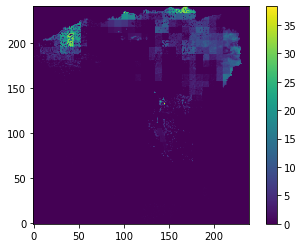

In [8]:
plt.imshow(diff, vmin=0., origin='lower')
plt.colorbar()


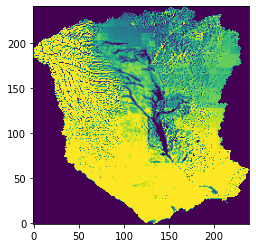

In [10]:
plt.imshow(zi, vmin=0., vmax=1500, origin='lower')

In [8]:
cbmi.finalize()

2020-06-05 15:29:58,249 - GLOFRIM - INFO - finalize models bmi. Close loggers.
2020-06-05 15:29:58,250 - GLOFRIM.WFL - INFO - finalize bmi. Close logger.
2020-06-05 15:29:58,252 - wflow_sbm_inc_cap.ini - wflow_sbm - INFO - Saving initial conditions...
2020-06-05 15:29:58,257 - wflow_sbm_inc_cap.ini - wf_DynamicFramework - INFO - Saving summary maps to disk...
2020-06-05 15:29:58,273 - wflow_sbm_inc_cap.ini - wf_netcdfio - WARNING - Finishing before expected run-length exceeded. Buffer not flushed
2020-06-05 15:29:58,276 - GLOFRIM.LFP - INFO - finalize bmi. Close logger.
